CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


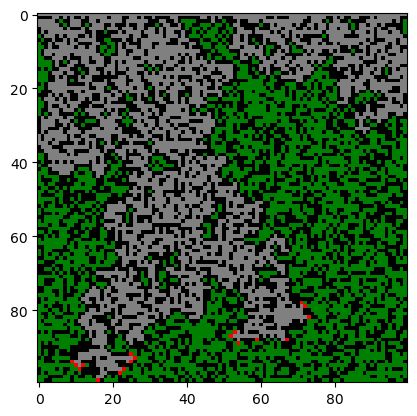

In [2]:
from itertools import product
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

Nx, Ny = Nxy = (100, 100)
rng = np.random.default_rng(seed=2024) # choose random seed 
pc = 0.5927460507921 # averaged percolation threshold from Albinet 

# 0: No tree
# 1: Living tree
# 2: Burning tree
# 3: Burnt tree

# randomly chooses 0 or 1 for size (100,100), probabilty range from percolation threshold
X = rng.choice(2, size=Nxy, p=[1-pc, pc]) # initialize grid with trees and no trees 

# Make slightly large array to add ghost-points to simplify testing
X0_ = np.zeros((Nx+2, Ny+2))
X0_[1:-1, 1:-1] = X
X0_[1, 1:-1] = 2   # Burning top row

# Some plotting routines
cm = ListedColormap(["black", "green", "red", "grey"])
def draw(X_, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.imshow(X_[1:-1, 1:-1], cmap=cm, vmin=0, vmax=3)

def update(X_):
    Nx, Ny = X_[1:-1, 1:-1].shape
    Xnew_ = X_.copy()
    percolated = False
    for nx, ny in product(range(1, Nx+1), range(1, Ny+1)):
        # If tree is alive and any neighbours on fire...
        if (X_[nx, ny] == 1 and any(np.array(
                [X_[nx-1, ny], X_[nx+1, ny], X_[nx, ny-1], X_[nx, ny+1]]) == 2)):
            Xnew_[nx, ny] = 2  # New tree is on fire.
        elif X_[nx, ny] == 2:  # If tree is on fire
            Xnew_[nx, ny] = 3  # New tree is burnt
        if nx == Nx and Xnew_[nx,ny] == 2:
            percolated = True
    return Xnew_, percolated 


# evolve for 50 steps - see how far it went 
# use length as proxy 
# take limit for large grid at percolation threshold 

# start with a large grid and start burning tree in the center 
# increase grid by vecorizing 
# write tests 
# set up one tree and make sure fire burns in write direction 

X_ = X0_
percolated = False 

%time 
for n in range(200): 
    X_, percolated = update(X_)
    if percolated:
        break
draw(X_)


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.39 µs


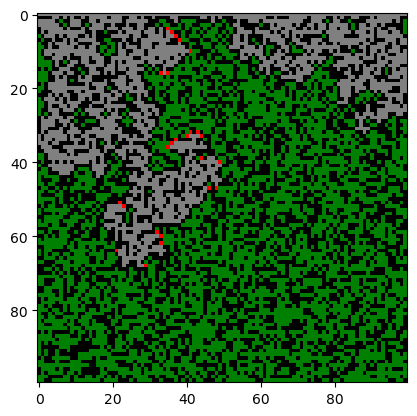

In [55]:
def update1(X_):
    Nx, Ny = X_[1:-1, 1:-1].shape
    Xnew_ = X_.copy()
    burning = np.where(X_ ==  2)
    Xnew_[burning] = 3

    percolated = False
    
    for ix, iy in zip(*burning):
        for d in (-1, +1):
            if X_[ix+d, iy] == 1:
                Xnew_[ix+d, iy] = 2
            if X_[ix, iy+d] == 1:
                Xnew_[ix, iy+d] = 2
            if ix == Nx:
                percolated = True

    return Xnew_, percolated 

# X_ = X0_
# %time for n in range(100): X_ = update1(X_)
# draw(X_)

X_ = X0_
percolated = False 
runs = 100

%time 
for n in range(runs): 
    X_, percolated = update1(X_)
    if percolated:
        break
draw(X_)


In [1]:
# generate number of runs (percolation threshold) and plot 
# bond percolation 
# each bit corresponds to one bond (1-4) 

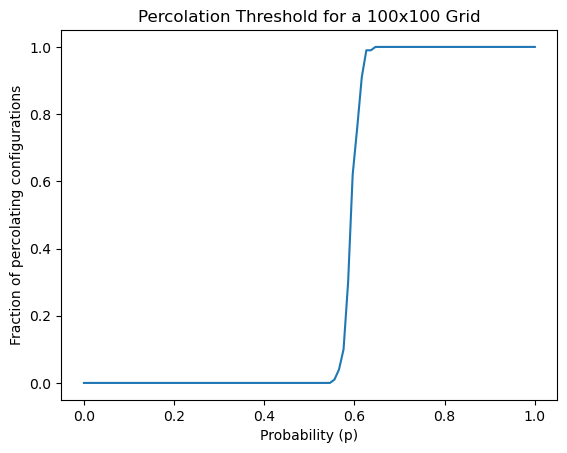

In [57]:
def percolation_threshold(Nxy, trials):
    results = []
    # probability 
    for p in np.linspace(0, 1, num=100):
        pc_count = 0
        for i in range(trials):
            # X = np.random.choice(2, size=Nxy, p=[1-p, p])
            # use the same grid as above but with probability threshold not dependent on the percolation threshold
            X = rng.choice(2, size=Nxy, p=[1-p, p])
            # if update1(X_)[1]:
            if has_percolating_path(X):
                pc_count += 1
        fraction_percolated = pc_count / trials
        results.append((p, fraction_percolated))
    return results

def has_percolating_path(lattice):
    # check for percolation using depth-first search
    def dfs(i, j, burning):
        # check if out of bounds
        if i < 0 or i >= len(lattice) or j < 0 or j >= len(lattice[0]) or lattice[i][j] == 0 or burning[i][j]:
            return False
        # otherwise 
        burning[i][j] = True
        if i == len(lattice) - 1:
            return True
        return (dfs(i+1, j, burning) or dfs(i-1, j, burning) or dfs(i, j+1, burning) or dfs(i, j-1, burning))
    
    burning = [[False]*len(lattice[0]) for i in range(len(lattice))]
    
    for j in range(len(lattice[0])):
        if dfs(0, j, burning):
            return True
    return False

# runs: Number of runs per probability
results = percolation_threshold(Nxy, runs)

# Plotting the results
plt.plot(*zip(*results))
plt.xlabel('Probability (p)')
plt.ylabel('Fraction of percolating configurations')
plt.title('Percolation Threshold for a 100x100 Grid')
plt.show()

In [58]:
results_ary = np.array(results)

In [59]:
# idx = np.where(results_ary[:,1] > 0.5)[0]
idx = np.where((results_ary[:,1] != 0.) & (results_ary[:,1] != 1.))[0]

array([55, 56, 57, 58, 59, 60, 61, 62, 63])

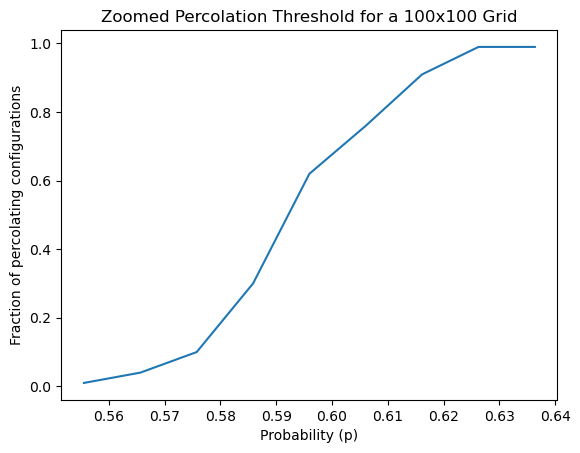

In [60]:
results_ = results_ary[idx]
plt.plot(*zip(*results_))
plt.xlabel('Probability (p)')
plt.ylabel('Fraction of percolating configurations')
plt.title('Zoomed Percolation Threshold for a 100x100 Grid')
plt.show()

In [62]:
# fit indices above to find center - least squares fit 
# sigmoid 1/(1+e^(-(x-pc))) to find transition  

from scipy.optimize import least_squares
# true percolation value: 0.5927460507921 

x = results_[:,0]
y_true = results_[:,1]
# y_true = 1 / (1 + np.exp(-(x-pc)))

def sigmoid(params, x):
    c, a, b = params
    return c / (1 + np.exp(-a * (x - b)))

# define residuals for least squares fitting
def sigmoid_residuals(params, x, y):
    return sigmoid(params, x) - y

# initial guess for the parameters
initial_guess = [1, 1, 0]  # [c, a, b]
# perform least squares fitting
result = least_squares(sigmoid_residuals, initial_guess, args=(x, y_true))
# find the center coordinate
center = result.x[2]

print("Center of the plot:", center)


Center of the plot: 0.5930894045892771
